# Preliminary Steps (Mandatory) and Data Normalization

- Create a kernel (or virtual environment, venv)
- Place the CSV file in the /csv folder

### Install Dependencies

In [ ]:
%pip install pandas
%pip install PyYAML
%pip install matplotlib
%pip install ipywidgets

### Read the CSVs and populate dictionary

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_folder = 'csv/'

# Get a list of CSV files in the folder
csv_files = glob.glob(csv_folder + '*.csv')
dfs=[]

# Check if any CSV files are found
if csv_files:
    for file in csv_files:
        # Load the CSV data into a pandas DataFrame
        df = pd.read_csv(file, skiprows=1)

        head_x = df['head'][1:].astype(float)  # Remove the first element and convert to float for plotting
        head_y = df['head.1'][1:].astype(float)  # Remove the first element and convert to float for plotting

        nose_x = df['nose'][1:].astype(float)  # Remove the first element and convert to float for plotting
        nose_y = df['nose.1'][1:].astype(float)  # Remove the first element and convert to float for plotting

        spine1_x = df['spine1'][1:].astype(float)  # Remove the first element and convert to float for plotting
        spine1_y = df['spine1.1'][1:].astype(float)  # Remove the first element and convert to float for plotting

        spine2_x = df['spine2'][1:].astype(float)  # Remove the first element and convert to float for plotting
        spine2_y = df['spine2.1'][1:].astype(float)  # Remove the first element and convert to float for plotting

        spine3_x = df['spine3'][1:].astype(float)  # Remove the first element and convert to float for plotting
        spine3_y = df['spine3.1'][1:].astype(float)  # Remove the first element and convert to float for plotting

        spine4_x = df['spine4'][1:].astype(float)  # Remove the first element and convert to float for plotting
        spine4_y = df['spine4.1'][1:].astype(float)  # Remove the first element and convert to float for plotting

        # Construct a dictionary with body parts coordinates
        bodyparts = {
            'head_x': head_x,
            'head_y': head_y,
            'nose_x': nose_x,
            'nose_y': nose_y,
            'spine1_x': spine1_x,
            'spine1_y': spine1_y,
            'spine2_x': spine2_x,
            'spine2_y': spine2_y,
            'spine3_x': spine3_x,
            'spine3_y': spine3_y,
            'spine4_x': spine4_x,
            'spine4_y': spine4_y,
        }
        
        # Perform additional processing or modification here
        filename = os.path.basename(file)
        
        # Split the string based on the underscore character
        parts = filename.split('.csv')[0].split('_')

        # Access the values at index 0 and 1
        name = parts[0]
        odorant = parts[1].split('DLC')[0]
    
        
        # Construct the object
        data_object = {
            'name': name,
            'odorant': odorant,
            'bodyparts': bodyparts
        }
        dfs.append(data_object)
        
# Dictionary to store grouped data objects
grouped_objects = {}

# Group data objects by odorant field
for df in dfs:
    odorant = df['odorant']
    if odorant not in grouped_objects:
        grouped_objects[odorant] = []
    grouped_objects[odorant].append(df)

##################################################
########## Populate Bodyparts Names Set ##########
##################################################

bp_names_set = set()  # Create an empty set

first_key = next(iter(grouped_objects))  # Get the first key
for bodypart in grouped_objects[first_key][0]['bodyparts']:
    common_name = bodypart[:-2]  # Extract common name by removing '_x' or '_y'
    bp_names_set.add(common_name)  # Add common name to the set

bp_names_set = sorted(bp_names_set)  # Sort the unique common names

## Truncate based on FPS and minutes

In [2]:
fps_count = 30
minutes = 3
max_size = fps_count*minutes*60

def truncate_series(series):
    '''
    if(len(series) < max_size):
        print(series.name)
        print('before ' + str(len(series)))
        print('after ' + str(len(series)))
    '''
    if len(series) > max_size:
        series = series.iloc[:max_size]  # Truncate the series
    return series

# Create a new dictionary to store truncated data objects grouped by odorant
truncated_grouped_objects = {}

# Loop through each data object
for obj in dfs:
    name = obj['name']
    odorant = obj['odorant']
    bodyparts = obj['bodyparts']
    
    # Create a new dictionary for the truncated data object
    truncated_obj = {
        'name': name,
        'odorant': odorant,
        'bodyparts': {}
    }
    
    # Truncate each series and store it in the new dictionary
    for key, value in bodyparts.items():
        truncated_obj['bodyparts'][key] = truncate_series(value)

    # Check if the odorant key exists in the new dictionary
    if odorant not in truncated_grouped_objects:
        truncated_grouped_objects[odorant] = []

    # Append the truncated data object to the list under the odorant key
    truncated_grouped_objects[odorant].append(truncated_obj)

grouped_objects = truncated_grouped_objects

## Strip NaNs

In [ ]:
i = 0
for odorant, objects in grouped_objects.items():
    for obj in objects:
        for bp_name in bp_names_set:
            series_x = obj['bodyparts'][f"{bp_name}_x"]
            series_y = obj['bodyparts'][f"{bp_name}_y"]
            
            # print(str(len(series_x))+ ' ' + str(len(series_y)))
            
            nan_indices_x = series_x.index[series_x.isnull()]
            nan_indices_y = series_y.index[series_y.isnull()]
            # Indices in nan_indices_x that are not in nan_indices_y
            indices_only_in_x = nan_indices_x.difference(nan_indices_y)
            
            # Indices in nan_indices_y that are not in nan_indices_x
            indices_only_in_y = nan_indices_y.difference(nan_indices_x)
            
            # print("Indices in nan_indices_x not in nan_indices_y:", indices_only_in_x)
            # print("Indices in nan_indices_y not in nan_indices_x:", indices_only_in_y)
            
            #unique_indexes = set(nan_indices_x + nan_indices_y)
            
            # Combine unique indices from both x and y
            unique_indexes = set(nan_indices_x).union(nan_indices_y)
            
            # Ensure unique_indexes exist in series_x and series_y
            unique_indexes_x = unique_indexes.intersection(series_x.index)
            unique_indexes_y = unique_indexes.intersection(series_y.index)
            
            # Remove indexes in unique_indexes_x and unique_indexes_y from series_x and series_y
            cleaned_series_x = series_x.drop(index=unique_indexes_x)
            cleaned_series_y = series_y.drop(index=unique_indexes_y)
            
            # print(str(len(cleaned_series_x))+ ' ' + str(len(cleaned_series_y)))

            obj['bodyparts'][f"{bp_name}_x"] = cleaned_series_x
            obj['bodyparts'][f"{bp_name}_y"] = cleaned_series_y

            i = i + 1

## Outilier removal using z-score

In [ ]:
def is_outlier(value, mean, std, threshold=3):
    z_score = np.abs((value - mean) / std)
    return z_score > threshold

i = 0
for odorant, objects in grouped_objects.items():
    for obj in objects:
        for bp_name in bp_names_set:
            series_x = pd.Series(obj['bodyparts'][f"{bp_name}_x"])
            series_y = pd.Series(obj['bodyparts'][f"{bp_name}_y"])
            mean_x = np.mean(series_x)
            mean_y = np.mean(series_y)
            std_x = np.std(series_x)
            std_y = np.std(series_y)
            
            # Ensure both series have the same length
            min_len = min(len(series_x), len(series_y))
            series_x = series_x[:min_len]
            series_y = series_y[:min_len]
            
            # Remove outliers
            mask = ~(series_x.apply(lambda x: is_outlier(x, mean_x, std_x)) | series_y.apply(lambda y: is_outlier(y, mean_y, std_y)))
            cleaned_series_x = series_x[mask]
            cleaned_series_y = series_y[mask]
            
            if len(cleaned_series_x) != len(cleaned_series_y):
                print(f"Length mismatch after outlier removal for obj {i}")
            
            obj['bodyparts'][f"{bp_name}_x"] = cleaned_series_x
            obj['bodyparts'][f"{bp_name}_y"] = cleaned_series_y
            i += 1

## Testing Util

In [3]:
for odorant, objects in grouped_objects.items():
    print(odorant + ' ' + str(len(objects)))
    for obj in objects:
        for bp_name in bp_names_set:
            if(len(obj['bodyparts'][f"{bp_name}_x"])  != len(obj['bodyparts'][f"{bp_name}_y"])):
                print(obj['name'] + ' ' + str(len(obj['bodyparts'][f"{bp_name}_x"])) + ' ' + str(len(obj['bodyparts'][f"{bp_name}_y"])))

2PEA 4
IAA 7
IND 7
ION 6
PUT 6
R-LEM 6
BEN 5
GUAI 1
H2O 6
HEX 4
S-LEM 5
2MP 6
TMT 5
ACP 3
ACP copy 1
HEX copy 1
2PEA copy 1


### Detect maximum values

In [4]:
max_values = {
    'absolute': {},
}

# Iterate over all data objects
for df in dfs:
    odorant = df['odorant']
    bodyparts = df['bodyparts']

    # Iterate over body parts in the current data object
    for bodypart, values in bodyparts.items():
        if bodypart not in max_values['absolute']:
            max_values['absolute'][bodypart] = float('-inf')
        
        # Update absolute maximum value for the body part
        max_values['absolute'][bodypart] = max(max_values['absolute'][bodypart], max(values))

        # Update maximum value for the body part within the current odorant
        if odorant not in max_values:
            max_values[odorant] = {}
        if bodypart not in max_values[odorant]:
            max_values[odorant][bodypart] = max(values)

# Convert absolute maximum values to floats
for bodypart in max_values['absolute']:
    max_values['absolute'][bodypart] = float(max_values['absolute'][bodypart])


## Create Dataframe widget selector
Used only in Single CSV Plot section

In [5]:
import ipywidgets as widgets
from IPython.display import display

# Assuming you have already defined grouped_objects dictionary

# Global variable to store the selected object
selected_df = None
selected_bp = None

# Create the first dropdown containing keys of the dictionary
odorant_dropdown = widgets.Dropdown(
    options=list(grouped_objects.keys()),
    description='Select odorant:'
)

# Create an empty dropdown for the second selection
mouse_dropdown = widgets.Dropdown(
    description='Select name:'
)

# Create an empty dropdown for the third selection
bp_dropdown = widgets.Dropdown(
    description='Select bodypart:'
)

# Function to update the options of the second dropdown based on the selection in the first dropdown
def update_mouse_dropdown(change):
    selected_odorant = change['new']
    mouse_dropdown.options = [obj['name'] for obj in grouped_objects[selected_odorant]]

# Attach the function to the first dropdown
odorant_dropdown.observe(update_mouse_dropdown, names='value')

# Function to update the options of the third dropdown based on the selection in the second dropdown
def update_bp_dropdown(change):
    selected_odorant = odorant_dropdown.value
    selected_name = change['new']
    unique_bodyparts = set()  # Set to collect unique common names
    for obj in grouped_objects[selected_odorant]:
        if obj['name'] == selected_name:
            for bodypart in obj['bodyparts']:
                common_name = bodypart[:-2]  # Extract common name by removing '_x' or '_y'
                unique_bodyparts.add(common_name)
            break
    sorted_bodyparts = sorted(unique_bodyparts)  # Sort the unique common names
    bp_dropdown.options = sorted_bodyparts

# Attach the function to the second dropdown
mouse_dropdown.observe(update_bp_dropdown, names='value')

# Function to handle the selection and store the corresponding object in selected_df and SELECTED_BP
def store_df_and_bp(odorant, name, bodypart):
    global selected_df, selected_bp
    selected_object = None
    for obj in grouped_objects[odorant]:
        if obj['name'] == name:
            selected_object = obj
            break
    selected_df = selected_object
    selected_bp = bodypart

# Event handler for the select_df_button click
def on_select_df_button_clicked(select_df_button):
    odorant = odorant_dropdown.value
    name = mouse_dropdown.value
    bodypart = bp_dropdown.value
    store_df_and_bp(odorant, name, bodypart)

# Create a select_df_button widget
select_df_button = widgets.Button(description="Select Dataframe")

# Attach the event handler to the select_df_button
select_df_button.on_click(on_select_df_button_clicked)


# Multi CSV Plots

## Scatter Plot Mean Coordinates

Change the value in BODYPART_TO_PLOT_SCATTER_MEAN to plot the mean euclidean distance change over time of all the odorants available

In [6]:
BODYPART_TO_PLOT_SCATTER_MEAN = 'head'

# Dictionary to store mean values of euclidean coordinates for each odorant
odorant_mean_coordinates = {}

# Iterate over each odorant
for odorant, objects in grouped_objects.items():
    odorant_mean_coordinates[odorant] = {}
    
    # Dictionary to store sum of the coordinates for each body part
    sum_coordinates = {}
    # Dictionary to store count of data objects for each body part
    count_objects = {}
    
    # Iterate over each data object for the current odorant
    for obj in objects:
        # Iterate over each body part array in the current data object
        for common_name, coordinates in obj['bodyparts'].items():
            if common_name not in sum_coordinates:
                sum_coordinates[common_name] = np.array(coordinates)
                count_objects[common_name] = 1
            else:
                # Pad the shorter array with NaN values to make them the same size
                max_len = max(len(sum_coordinates[common_name]), len(coordinates))
                padded_sum_coordinates = np.pad(sum_coordinates[common_name], (0, max_len - len(sum_coordinates[common_name])), mode='constant', constant_values=np.nan)
                padded_coordinates = np.pad(coordinates, (0, max_len - len(coordinates)), mode='constant', constant_values=np.nan)
                
                # Compute element-wise sum, considering NaN values
                sum_coordinates[common_name] = np.nansum([padded_sum_coordinates, padded_coordinates], axis=0)
                count_objects[common_name] += 1
    
    # Calculate mean values for each body part
    for common_name, sum_distance in sum_coordinates.items():
        mean_distance = sum_distance / count_objects[common_name]
        odorant_mean_coordinates[odorant][common_name] = mean_distance.tolist()

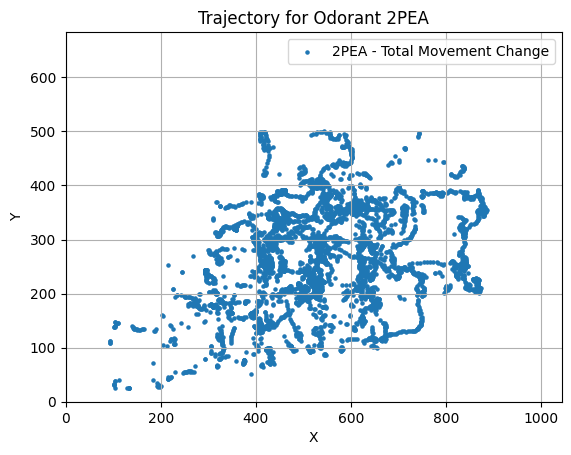

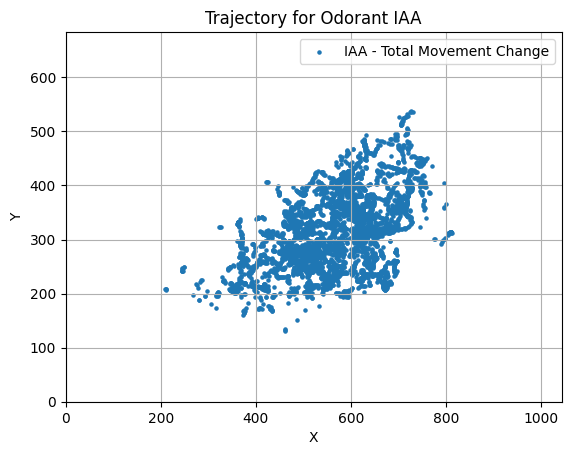

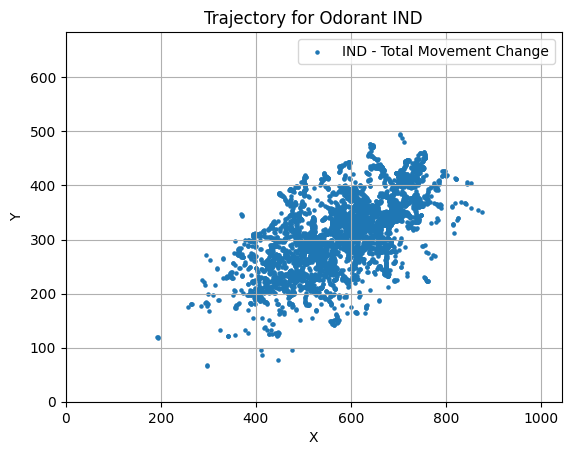

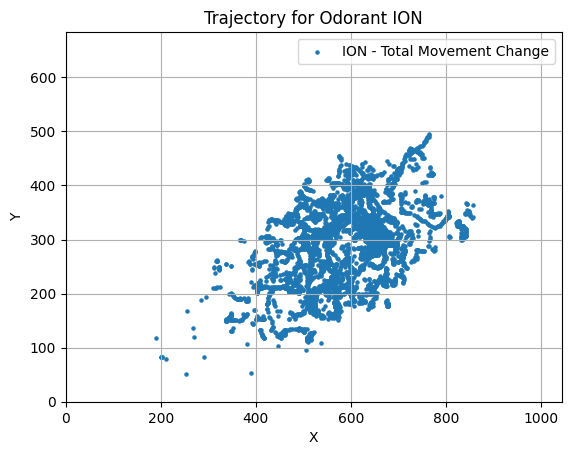

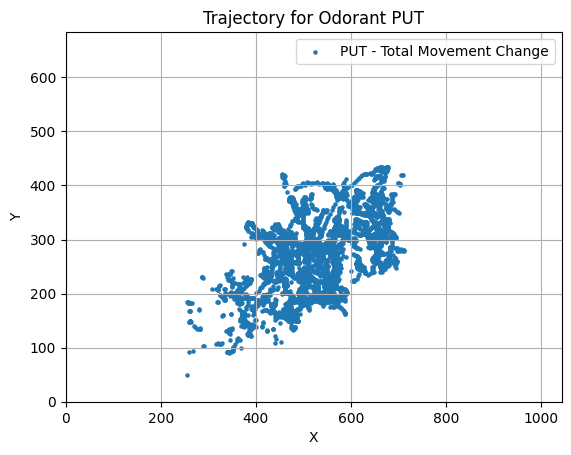

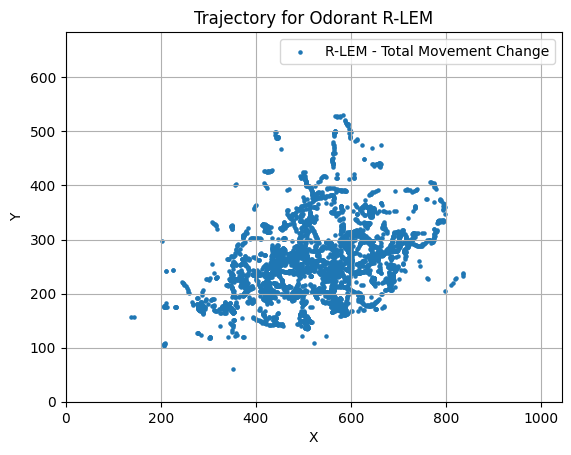

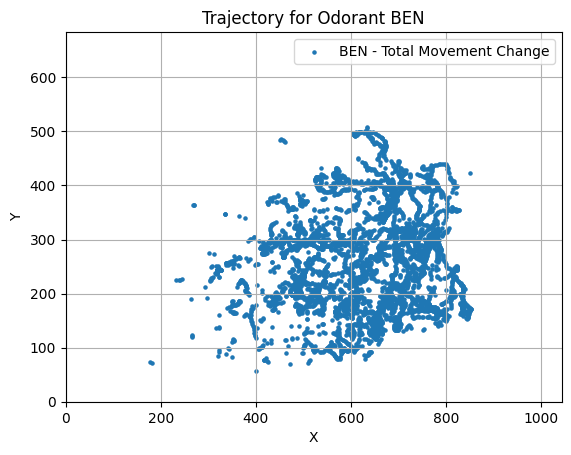

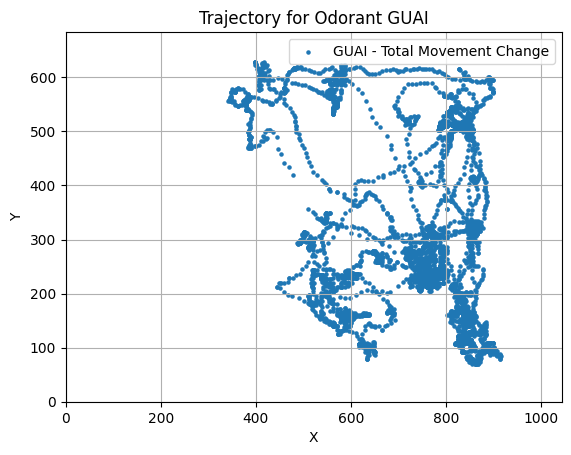

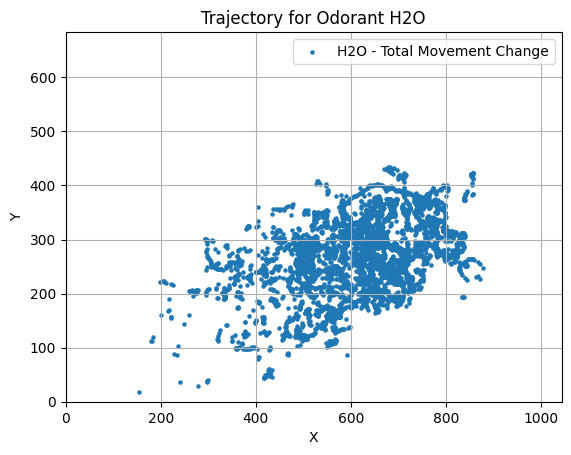

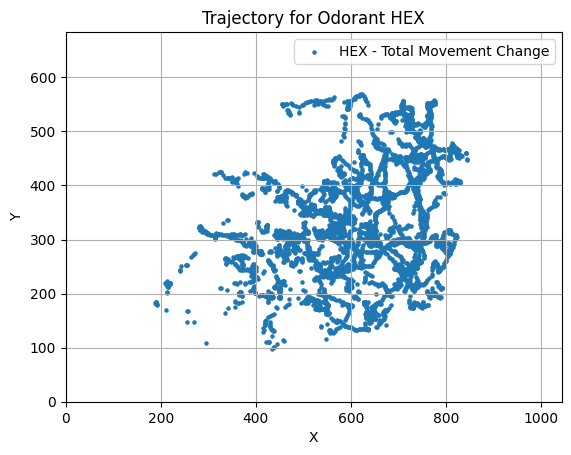

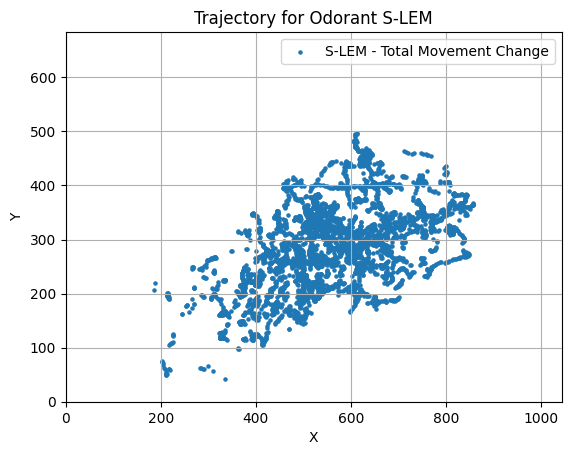

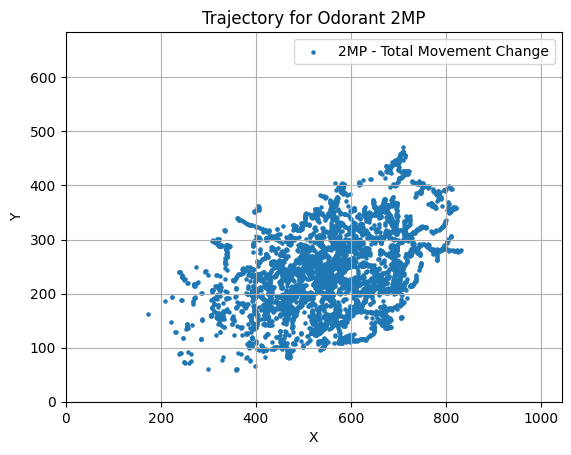

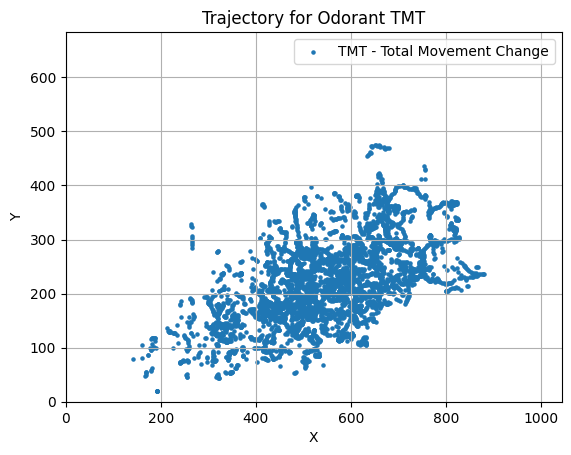

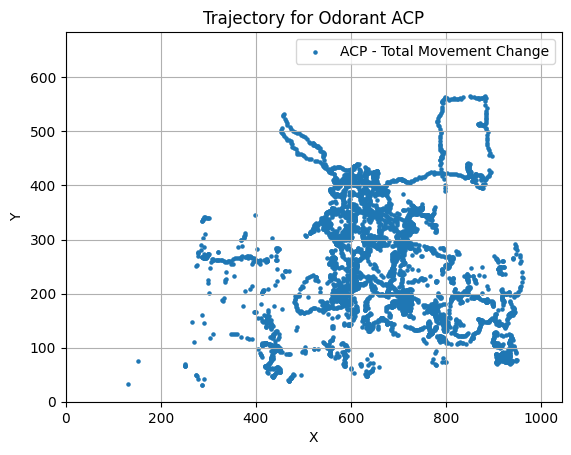

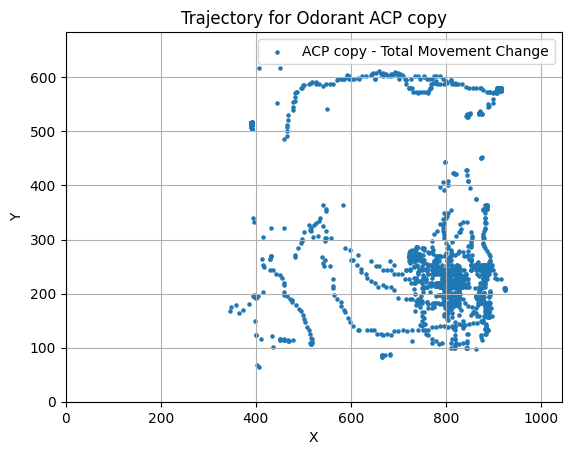

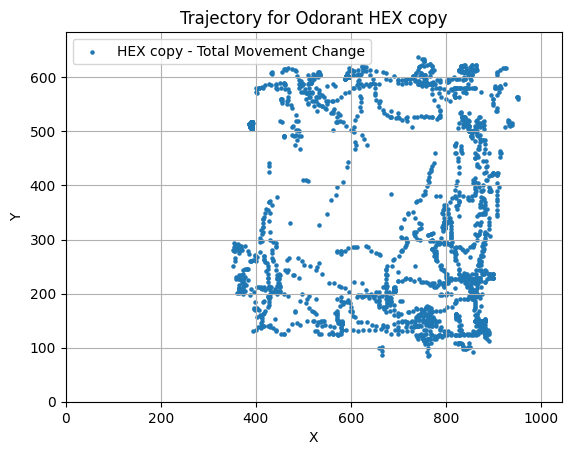

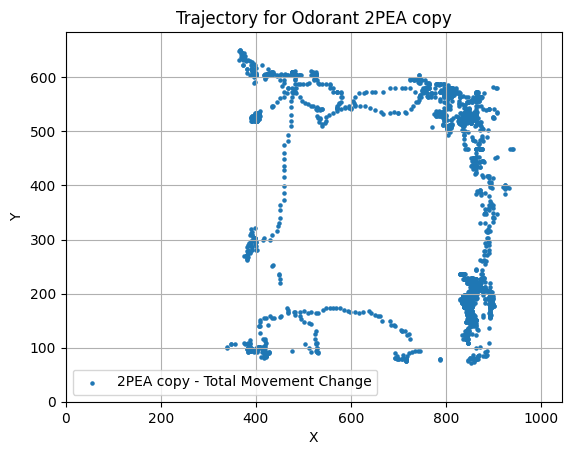

In [7]:
dot_size = 5

# Extract maximum x and y values from max_values dictionary
plot_lim_absolute_max_x = max_values['absolute'][f"{BODYPART_TO_PLOT_SCATTER_MEAN}_x"]
plot_lim_absolute_max_y = max_values['absolute'][f"{BODYPART_TO_PLOT_SCATTER_MEAN}_y"]

# Iterate over each odorant in odorant_mean_coordinates
for odorant, mean_coordinates in odorant_mean_coordinates.items():
    # Extract the mean distance for 'BODYPART_TO_PLOT_SCATTER_MEAN' for the current odorant
    bp_x = mean_coordinates[f"{BODYPART_TO_PLOT_SCATTER_MEAN}_x"]
    bp_y = mean_coordinates[f"{BODYPART_TO_PLOT_SCATTER_MEAN}_y"]
    
    # Plotting total movement change over time for the current odorant
    plt.figure()  # Create a new figure for each odorant
    plt.scatter(bp_x, bp_y, s=dot_size, label=f'{odorant} - Total Movement Change')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Trajectory for Odorant {odorant}')
    plt.legend()
    plt.grid(True)
    
    # Set x and y axis limits
    plt.xlim(0, plot_lim_absolute_max_x)
    plt.ylim(0, plot_lim_absolute_max_y)
    
    plt.show()

## Heatmap
Change the value in BODYPART_TO_PLOT_HEATMAP to generate an heatmap of different bodyparts

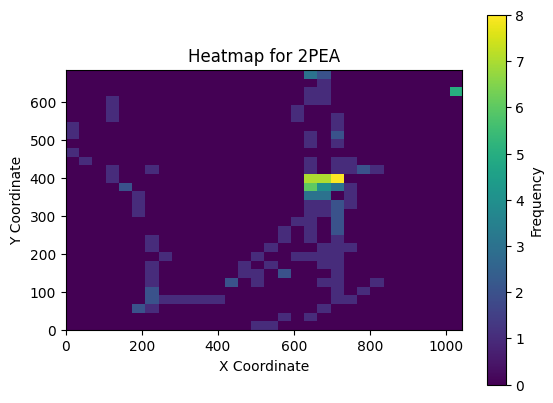

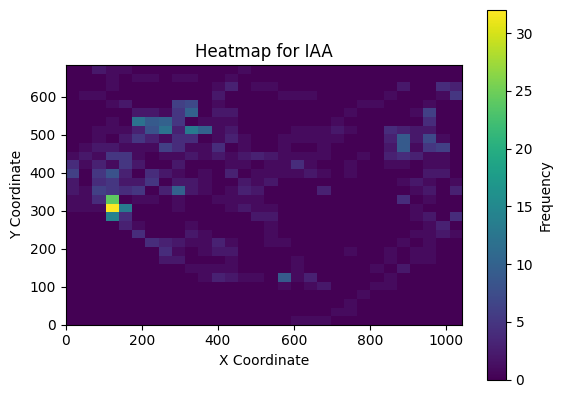

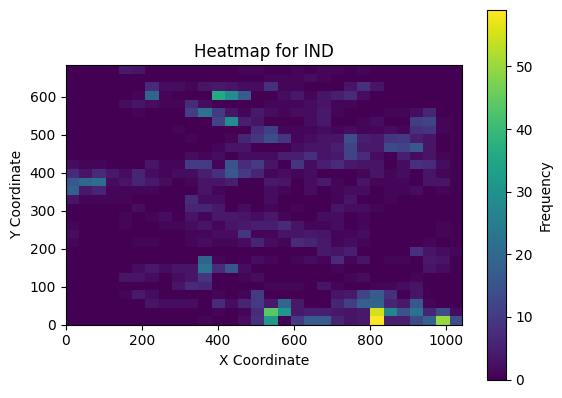

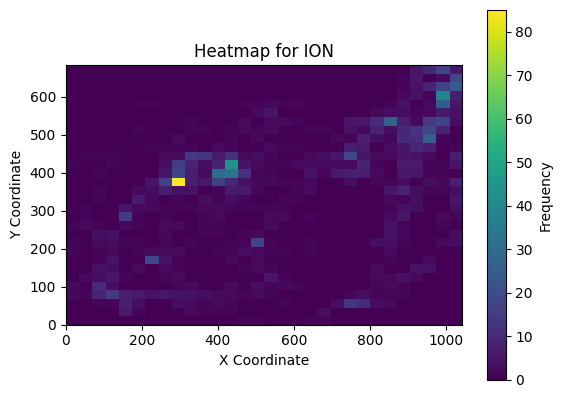

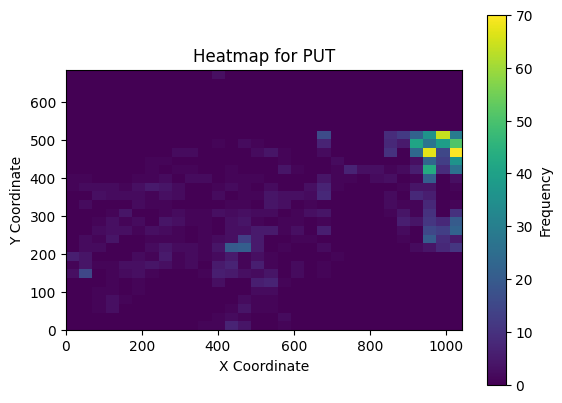

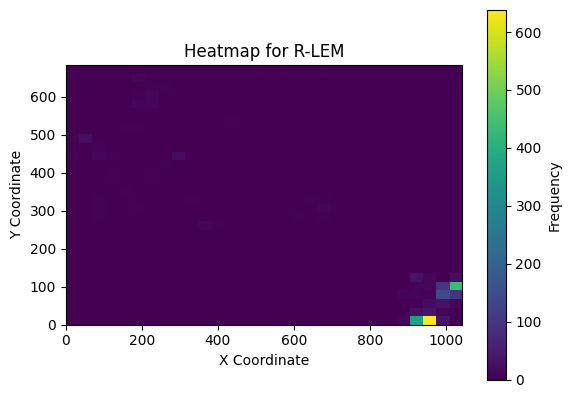

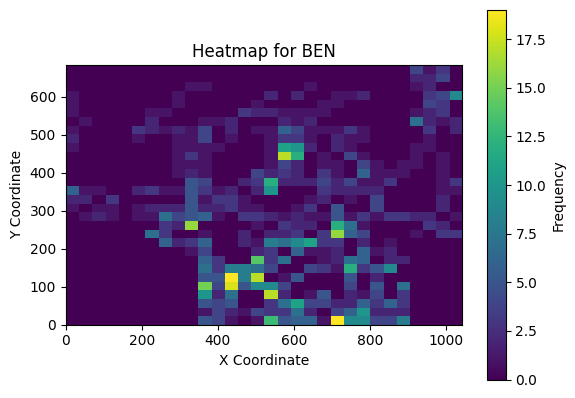

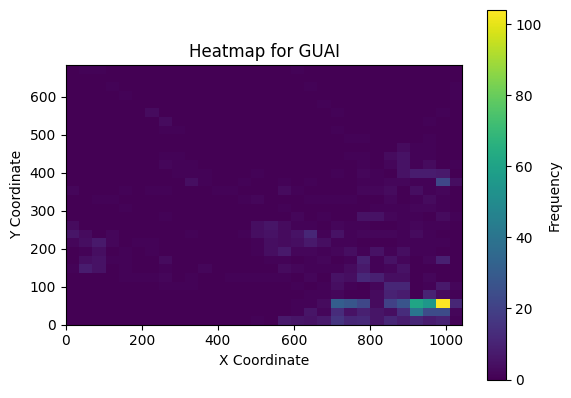

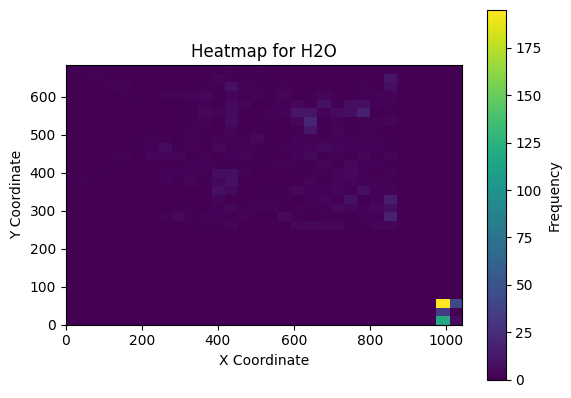

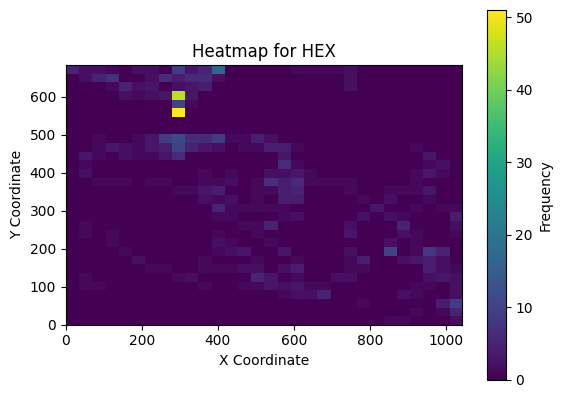

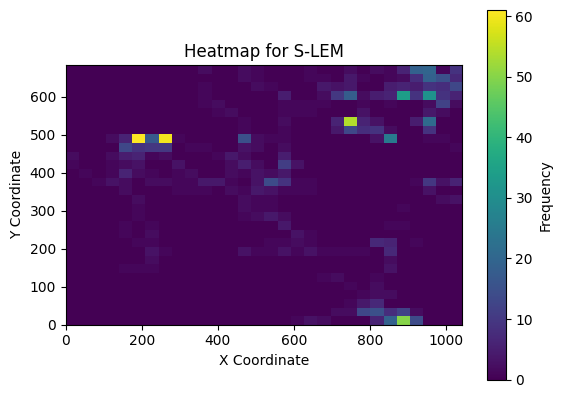

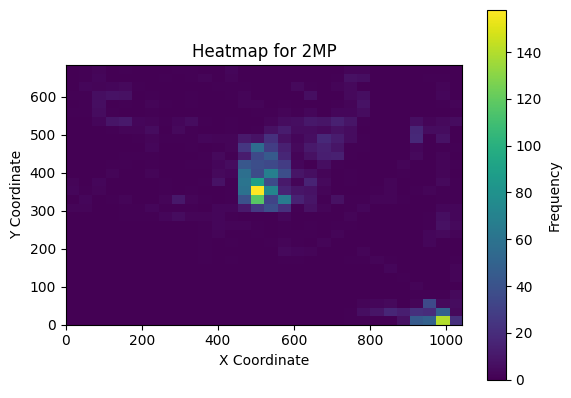

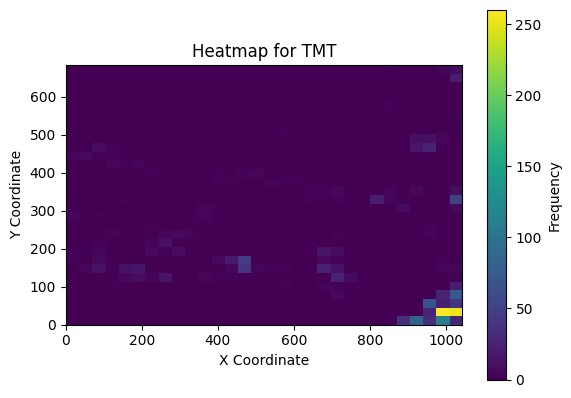

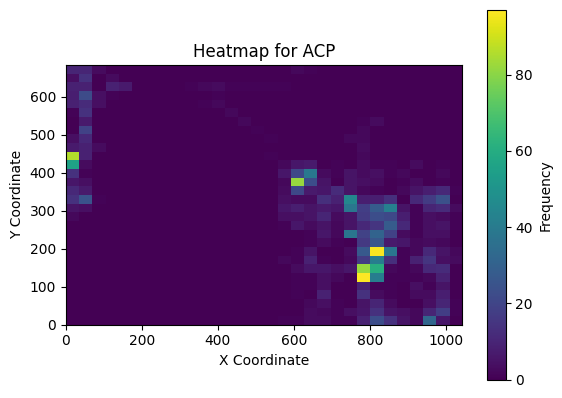

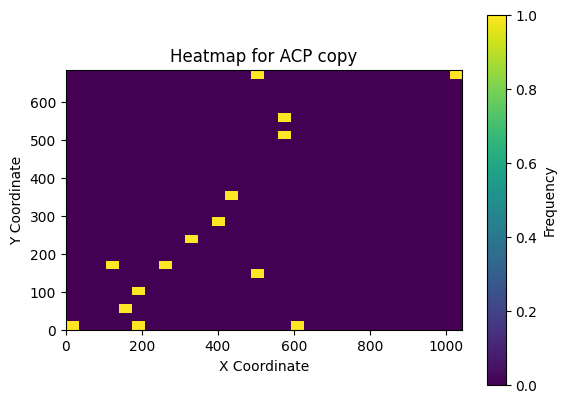

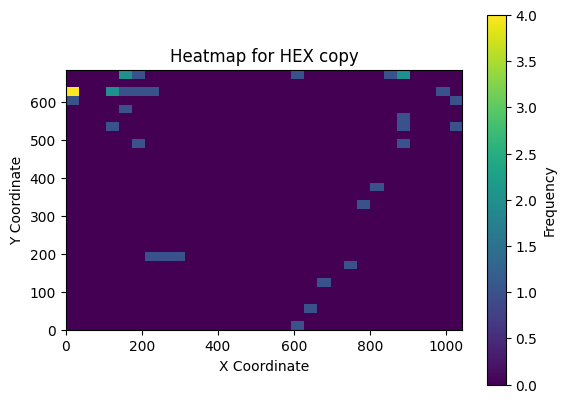

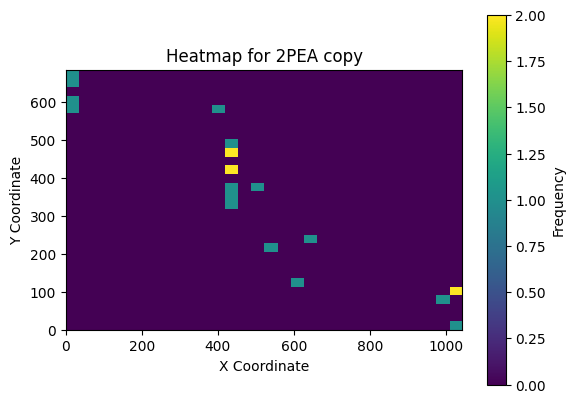

In [21]:
BODYPART_TO_PLOT_HEATMAP = 'head'

# Extract maximum x and y values from max_values dictionary
plot_lim_absolute_max_x = max_values['absolute'][f"{BODYPART_TO_PLOT_HEATMAP}_x"]
plot_lim_absolute_max_y = max_values['absolute'][f"{BODYPART_TO_PLOT_HEATMAP}_y"]

# Iterate over each odorant entry in the dictionary
for odorant_entry in grouped_objects:
    # Concatenate and remove NaN values
    head_x_concatenated = np.concatenate([entry['bodyparts'][f"{BODYPART_TO_PLOT_HEATMAP}_x"].dropna() for entry in grouped_objects[odorant_entry]])
    head_y_concatenated = np.concatenate([entry['bodyparts'][f"{BODYPART_TO_PLOT_HEATMAP}_y"].dropna() for entry in grouped_objects[odorant_entry]])

    # Create a 2D histogram (heatmap)
    heatmap, xedges, yedges = np.histogram2d(head_x_concatenated, head_y_concatenated, bins=(30, 30))

    # Plot the heatmap using plt.imshow()
    plt.imshow(heatmap.T, extent=[0, plot_lim_absolute_max_x, 0, plot_lim_absolute_max_y], origin='lower', cmap='viridis')
    plt.colorbar(label='Frequency')
    plt.title(f"Heatmap for {odorant_entry}")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    plt.show()


### Heatmaps multi scale

In [ ]:
BODYPART_TO_PLOT_HEATMAP = 'head'

# Iterate over each odorant entry in the dictionary
for odorant_entry in grouped_objects:
    # Concatenate and remove NaN values
    head_x_concatenated = np.concatenate([entry['bodyparts'][f"{BODYPART_TO_PLOT_HEATMAP}_x"].dropna() for entry in grouped_objects[odorant_entry]])
    head_y_concatenated = np.concatenate([entry['bodyparts'][f"{BODYPART_TO_PLOT_HEATMAP}_y"].dropna() for entry in grouped_objects[odorant_entry]])

    # Create a 2D histogram (heatmap)
    plt.hist2d(x=head_x_concatenated, y=head_y_concatenated, bins=(30, 30), cmap='viridis')
    plt.colorbar(label='Frequency')
    plt.title(f"Heatmap for {odorant_entry}")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

### Heathmap to CSV

In [ ]:
BODYPART_TO_PLOT_HEATMAP = 'head'


# Assuming you have defined BODYPART_TO_PLOT_HEATMAP, max_values, and grouped_objects already

# Initialize an empty list to store heatmap data for all odorants
all_heatmap_data = []

# Iterate over each odorant entry in the dictionary
for odorant_entry in grouped_objects:
    # Concatenate and remove NaN values
    head_x_concatenated = np.concatenate([entry['bodyparts'][f"{BODYPART_TO_PLOT_HEATMAP}_x"].dropna() for entry in grouped_objects[odorant_entry]])
    head_y_concatenated = np.concatenate([entry['bodyparts'][f"{BODYPART_TO_PLOT_HEATMAP}_y"].dropna() for entry in grouped_objects[odorant_entry]])

    # Create a 2D histogram (heatmap)
    heatmap, xedges, yedges = np.histogram2d(head_x_concatenated, head_y_concatenated, bins=(30, 30))

    # Append the heatmap data to the list
    all_heatmap_data.append(heatmap)

    # Plot the heatmap using plt.imshow()
    plt.imshow(heatmap.T, extent=[0, plot_lim_absolute_max_x, 0, plot_lim_absolute_max_y], origin='lower', cmap='viridis')
    plt.colorbar(label='Frequency')
    plt.title(f"Heatmap for {odorant_entry}")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')

    plt.show()

# Convert the list of 2D arrays into a single 3D array
all_heatmap_data = np.array(all_heatmap_data)

# Flatten the 3D array into a 2D array
flattened_heatmap_data = all_heatmap_data.reshape(all_heatmap_data.shape[0], -1)

# Save all heatmap data to a CSV file
np.savetxt('heatmap_data.csv', flattened_heatmap_data, delimiter=',')

## Euclidean Distance Change

In [ ]:
def process_euclidean_distance(x, y):
    # Assuming x and y are Pandas Series
    # Calculate differences between consecutive coordinates
    dx = x.diff().iloc[1:]  # Calculate differences in x-coordinates
    dy = y.diff().iloc[1:]  # Calculate differences in y-coordinates

    # Calculate Euclidean distance between consecutive points
    movement_change = np.sqrt(dx**2 + dy**2)
    
    return movement_change

# Dictionary to store grouped data objects with euclidean distances
grouped_objects_euclidean_distance = {}

# Iterate over each odorant
for odorant, objects in grouped_objects.items():
    grouped_objects_euclidean_distance[odorant] = []
    
    # Iterate over each data object for the current odorant
    for obj in objects:
        euclidean_distances = {}
        # Iterate over each body part array in the current data object
        for bodypart in obj['bodyparts']:
            # Extract the common name by removing the '_x' or '_y' suffix
            common_name = bodypart[:-2]
            # Check if both '_x' and '_y' keys exist for the current common name
            if f"{common_name}_x" in obj['bodyparts'] and f"{common_name}_y" in obj['bodyparts']:
                x_key = f"{common_name}_x"
                y_key = f"{common_name}_y"
                euclidean_distance = process_euclidean_distance(obj['bodyparts'][x_key], obj['bodyparts'][y_key])
                euclidean_distances[common_name] = euclidean_distance.tolist()
        
        # Append to grouped_objects_euclidean_distance dictionary
        grouped_objects_euclidean_distance[odorant].append({
            'name': obj['name'],
            'euclidean_distance': euclidean_distances
        })
        
        
# Dictionary to store mean values of euclidean distances for each odorant
odorant_mean_distances = {}

# Iterate over each odorant
for odorant, objects in grouped_objects_euclidean_distance.items():
    odorant_mean_distances[odorant] = {}
    
    # Dictionary to store sum of euclidean distances for each body part
    sum_distances = {}
    # Dictionary to store count of data objects for each body part
    count_objects = {}
    
    # Iterate over each data object for the current odorant
    for obj in objects:
        # Iterate over each body part array in the current data object
        for common_name, distances in obj['euclidean_distance'].items():
            if common_name not in sum_distances:
                sum_distances[common_name] = np.array(distances)
                count_objects[common_name] = 1
            else:
                # Pad the shorter array with NaN values to make them the same size
                max_len = max(len(sum_distances[common_name]), len(distances))
                padded_sum_distances = np.pad(sum_distances[common_name], (0, max_len - len(sum_distances[common_name])), mode='constant', constant_values=np.nan)
                padded_distances = np.pad(distances, (0, max_len - len(distances)), mode='constant', constant_values=np.nan)
                
                # Compute element-wise sum, considering NaN values
                sum_distances[common_name] = np.nansum([padded_sum_distances, padded_distances], axis=0)
                count_objects[common_name] += 1
    
    # Calculate mean values for each body part
    for common_name, sum_distance in sum_distances.items():
        mean_distance = sum_distance / count_objects[common_name]
        odorant_mean_distances[odorant][common_name] = mean_distance.tolist()

          

### All odorants comparison

Change the value in BODYPART_TO_PLOT_EUCLIDEAN_DISTANCE_CHANGE_ALL to plot the mean euclidean distance change over time of all the odorants available

In [ ]:
BODYPART_TO_PLOT_EUCLIDEAN_DISTANCE_CHANGE_ALL = 'head'

plt.figure(figsize=(25,15), dpi= 300)

for odorant, mean_distance in odorant_mean_distances.items():
    bp_to_plot = mean_distance[BODYPART_TO_PLOT_EUCLIDEAN_DISTANCE_CHANGE_ALL]
    # Assuming time is represented by indices
    time = range(1, len(bp_to_plot) + 1)
    
    # Plotting total movement change over time for the current odorant
    plt.plot(time, bp_to_plot, label=f'{odorant} - Total Movement Change', linewidth=0.2)

plt.xlabel('Time')
plt.ylabel('Total Movement Change')
plt.title('Total Movement Change over Time for Each Odorant')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### Multiple Charts

Change the value in BODYPART_TO_PLOT_EUCLIDEAN_DISTANCE_CHANGE to plot the mean euclidean distance change over time of all the odorants available in <b>multiple charts</b>

In [ ]:
BODYPART_TO_PLOT_EUCLIDEAN_DISTANCE_CHANGE = 'head'

# Iterate over each odorant in odorant_mean_distances
for odorant, mean_distances in odorant_mean_distances.items():
    # Extract the mean distance for BODYPART_TO_PLOT_EUCLIDEAN_DISTANCE_CHANGE for the current odorant
    bp_to_plot = mean_distances[BODYPART_TO_PLOT_EUCLIDEAN_DISTANCE_CHANGE]
    
    # Assuming time is represented by indices
    time = range(1, len(bp_to_plot) + 1)
    print(time)
    
    # Plotting total movement change over time for the current odorant
    plt.figure()  # Create a new figure for each odorant
    plt.plot(time, bp_to_plot, label=f'{odorant} - Total Movement Change', linewidth=0.2)
    
    plt.xlabel('Time')
    plt.ylabel('Total Movement Change')
    plt.title(f'Total Movement Change over Time for Odorant {odorant}')
    plt.legend()
    plt.grid(True)
    plt.show()


# Single CSV Plot

In [ ]:
# Display the widgets
display(odorant_dropdown, mouse_dropdown, bp_dropdown, select_df_button)


## Line Plot

In [ ]:
bp_x = selected_df['bodyparts'][f"{selected_bp}_x"]
bp_y = selected_df['bodyparts'][f"{selected_bp}_y"]
bp_x_label = f"{selected_bp}_x"
bp_y_label = f"{selected_bp}_y"

# Generate indices starting from 1
indices = range(1, len(bp_x) + 1)

# Plot head_x and head_y
plt.plot(indices, bp_x, label=bp_x_label)
plt.plot(indices, bp_y, label=bp_y_label)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Pixel Coordinates')
plt.legend()

# Show the plot
plt.show()

## Change in 2D Coordinates over Time

In [ ]:
bp_x = selected_df['bodyparts'][f"{selected_bp}_x"]
bp_y = selected_df['bodyparts'][f"{selected_bp}_y"]

# Assuming bp_x and bp_y are Pandas Series
# Calculate differences between consecutive coordinates
dx = bp_x.diff().iloc[1:]  # Calculate differences in x-coordinates
dy = bp_y.diff().iloc[1:]  # Calculate differences in y-coordinates

# Assuming time is represented by indices
time = range(1, len(dx) + 1)

# Plotting
plt.plot(time, dx, label='Change in X Coordinate', marker='o')  # Plotting change in x-coordinate
plt.plot(time, dy, label='Change in Y Coordinate', marker='s')  # Plotting change in y-coordinate
plt.xlabel('Time')
plt.ylabel('Change in Coordinate Value')
plt.title('Change in 2D Coordinates over Time')
plt.legend()
plt.grid(True)
plt.show()

## Total Movement Change (Euclidean Distance)

In [ ]:
bp_x = selected_df['bodyparts'][f"{selected_bp}_x"]
bp_y = selected_df['bodyparts'][f"{selected_bp}_y"]

# Assuming bp_x and bp_y are Pandas Series
# Calculate differences between consecutive coordinates
dx = bp_x.diff().iloc[1:]  # Calculate differences in x-coordinates
dy = bp_y.diff().iloc[1:]  # Calculate differences in y-coordinates

# Calculate Euclidean distance between consecutive points
movement_change = np.sqrt(dx**2 + dy**2)

# Assuming time is represented by indices
time = range(1, len(movement_change) + 1)

# Plotting total movement change over time as a line plot
plt.plot(time, movement_change, label='Total Movement Change', linewidth=0.2)
plt.xlabel('Time')
plt.ylabel('Total Movement Change')
plt.title('Total Movement Change over Time')
plt.legend()
plt.grid(True)
plt.show()

## Scatter Plot Coordinates

In [ ]:
# Decrease the size of the dots
dot_size = 5  # Adjust the size as needed

bp_head_x = selected_df['bodyparts']['head_x']
bp_head_y = selected_df['bodyparts']['head_y']
spine1_x = selected_df['bodyparts']['spine1_x']
spine1_y = selected_df['bodyparts']['spine1_y']
spine2_x = selected_df['bodyparts']['spine2_x']
spine2_y = selected_df['bodyparts']['spine2_y']
spine3_x = selected_df['bodyparts']['spine3_x']
spine3_y = selected_df['bodyparts']['spine3_y']
spine4_x = selected_df['bodyparts']['spine4_x']
spine4_y = selected_df['bodyparts']['spine4_y']
nose_x = selected_df['bodyparts']['nose_x']
nose_y = selected_df['bodyparts']['nose_y']

# Plot x vs y axis
plt.scatter(bp_head_x, bp_head_y, s=dot_size, label='Head')
plt.scatter(spine1_x, spine1_y, s=dot_size, label='Spine1')
plt.scatter(spine2_x, spine2_y, s=dot_size, label='Spine2')
plt.scatter(spine3_x, spine3_y, s=dot_size, label='Spine3')
plt.scatter(spine4_x, spine4_y, s=dot_size, label='Spine4')
plt.scatter(nose_x, nose_y, s=dot_size, label='Nose')

# Add labels
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

# Utilities

## H5 to CSV converter and adapter

In [ ]:
import pandas as pd
import yaml
import os
import csv

# Define the directory paths
h5_directory = 'h5'  # Directory containing HDF5 files
csv_directory = 'csv'  # Directory to save CSV files

# Create the CSV directory if it doesn't exist
os.makedirs(csv_directory, exist_ok=True)

# Body parts to rename
bodyparts_to_rename = [
    ('left_ear', 'left ear'),
    ('right_ear', 'right ear'),
    ('neck', 'spine1'),
    ('mouse_center', 'spine2'),
    ('mid_backend2', 'spine3'),
    ('tail_base', 'spine4'),
    ('tail_end', 'tail'),
    ('head_midpoint', 'head')
]

# Load the YAML file
file_paths = ['config.yaml', 'config.yml']

for file_path in file_paths:
    try:
        with open(file_path, 'r') as file:
            config = yaml.safe_load(file)
            break  # Break the loop if configuration is loaded successfully
    except FileNotFoundError:
        continue  # Continue to the next file if the current one doesn't exist
else:
    print("No configuration file found.")

# Extract body parts from the config
bodyparts = config['bodyparts']

# Cleanup CSV folder
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        os.remove(os.path.join(csv_directory, filename))

# Function to process a single HDF5 file
def process_h5_file(file_path):
    def rename_bodypart(bodypart):
        for original_name, new_name in bodyparts_to_rename:
            if bodypart == original_name:
                return new_name
        return bodypart
    
    # Read HDF5 file
    df = pd.read_hdf(file_path)
    
    # Rename body parts in the DataFrame columns
    new_index = [(scorer, rename_bodypart(bodypart), coords) for scorer, bodypart, coords in df.columns]
    new_columns = pd.MultiIndex.from_tuples(new_index, names=df.columns.names)
    df.columns = new_columns
    
    # Drop columns not in the bodyparts list
    for col in df.columns:
        if col[1] not in bodyparts:
            df.drop(columns=[col], inplace=True)
    
    # Extract file name and remove extension
    file_name = os.path.basename(file_path)
    file_name_no_ext = os.path.splitext(file_name)[0]
    
    # Construct new CSV file path
    new_csv_path = os.path.join(csv_directory, f'tmp_{file_name_no_ext}.csv')
    
    # Save DataFrame to CSV
    df.to_csv(new_csv_path, index=False)

def process_csv_files(file_path):
    def custom_key(item):
        second_value_index = bodyparts.index(item[1])
        third_value_index = order_third_value.index(item[2])
        return (second_value_index, third_value_index)

    def read_csv(filename):
        matrix = []
        with open(filename, 'r') as file:
            reader = csv.reader(file)
            # Read the header to get column names
            header = next(reader)
            # Initialize matrix with header names as the first value
            matrix = [[col] for col in header]
            
            # Read the rest of the rows
            for row in reader:
                for i, value in enumerate(row):
                    matrix[i].append(value)
        return matrix
    
    def write_csv(matrix, filename):
        new_csv_path = filename.replace("tmp_", "")
        # Write the sorted matrix to a CSV file
        with open(new_csv_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            transposed_matrix = list(zip(*matrix))
            for row in transposed_matrix:
                    writer.writerow(row)

    def push_heading_row(matrix):
            # New array to add
            new_array = ['scorer', 'bodyparts', 'coords']
            # Get the maximum size of arrays
            max_size = max(len(row) for row in matrix) - 3
            # Iterate over max_size and construct strings
            for i in range(max_size):
                # Format the number with leading zeros
                frame_str = "frame{:04d}".format(i)
                # Append the formatted string to new_array
                new_array.append(frame_str)
            # Shift all elements down by one row
            matrix.insert(0, new_array)

    # Define the order for the third value
    order_third_value = ['x', 'y', 'likelihood']
    
    # Read the csv and store it in a matrix
    original_matrix = read_csv(file_path)
    
    # Sort the matrix using the custom key function
    sorted_matrix = sorted(original_matrix, key=custom_key)
    
    # Add as position 0 in the matrix an array containing keys 'scorer', 'bodyparts', 'coords' and the frame name    
    push_heading_row(sorted_matrix)
    
    # Write the matrix in a csv file by transposing the matrix    
    write_csv(sorted_matrix, file_path)
    
    # Remove tmp file
    os.remove(file_path)

# Iterate over HDF5 files in the directory
for filename in os.listdir(h5_directory):
    if filename.endswith('.h5'):
        h5_file_path = os.path.join(h5_directory, filename)
        process_h5_file(h5_file_path)
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        csv_file_path = os.path.join(csv_directory, filename)
        process_csv_files(csv_file_path)